<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_roc_auc_with_uid_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [1]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

In [2]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 108MB/s]
 91% 53.0M/58.3M [00:00<00:00, 45.2MB/s]
100% 58.3M/58.3M [00:00<00:00, 63.4MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 77.5MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 109MB/s]
100% 52.0M/52.2M [00:00<00:00, 69.0MB/s]
100% 52.2M/52.2M [00:00<00:00, 88.9MB/s]


loading drive

In [3]:
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


Loading dataframes

In [4]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train_id.csv',index_col=[0],nrows=10)

In [6]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train_id.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test_id.csv',index_col=[0])
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C9_std_isna,C10_std_isna,C11_std_isna,C12_std_isna,C13_std_isna,C14_std_isna,D1_mean_isna,D1_std_isna,D2_mean_isna,D2_std_isna,D3_mean_isna,D3_std_isna,D4_mean_isna,D4_std_isna,D5_mean_isna,D5_std_isna,D6_mean_isna,D6_std_isna,D7_mean_isna,D7_std_isna,D8_mean_isna,D8_std_isna,D9_mean_isna,D9_std_isna,D10_mean_isna,D10_std_isna,D11_mean_isna,D11_std_isna,D12_mean_isna,D12_std_isna,D13_mean_isna,D13_std_isna,D14_mean_isna,D14_std_isna,D15_mean_isna,D15_std_isna,V1_mean_isna,V1_std_isna,isFraud,id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,Wnan315.013926-13.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,Wgmail.com325.027551.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,Woutlook.com330.046631.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,Wyahoo.com476.018132-111.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Hgmail.com420.044971.0


Reduce memory useage

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2793.39 MB
Memory usage after optimization is: 678.37 MB
Decreased by 75.7%
Memory usage of dataframe is 2392.90 MB
Memory usage after optimization is: 580.09 MB
Decreased by 75.8%


In [8]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [9]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data,epochs):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0
        self.epochs=epochs
        self.val=0
        self.wts=[]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        if roc_val>self.val:
          self.val=roc_val
          self.epoch=10
          self.wts=self.model.get_weights()
        else:
          self.epoch-=1
        if self.epoch==0:
          self.model.set_weights(self.wts)
          self.model.stop_training = True
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model(dim):
  K.clear_session()


  uid=Input((1,))
  inp=Input((873,))
  emb=Embedding(input_dim=dim,output_dim=4)(uid)
  emb=Flatten()(emb)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  emb=Flatten()(emb)
  x=Concatenate()([emb,x])
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp,uid],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

Adding all datasets

In [10]:
trn_s=trn.shape[0]
df=pd.concat([trn,tst],0).reset_index(drop=True)
del([trn,tst])
gc.collect()


autoenc=pd.read_csv('/content/gdrive/My Drive/fraud/without_id.csv',index_col=[0])

autoenc.columns=[i for i in range(444,444+autoenc.shape[1])]


df=pd.concat([df,autoenc],1)
df=reduce_mem_usage(df)
del([autoenc])
gc.collect()

trn=df.loc[:trn_s-1]
tst=df.loc[trn_s:].reset_index(drop=True)
del([df])
gc.collect()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of dataframe is 3384.06 MB
Memory usage after optimization is: 1783.79 MB
Decreased by 47.3%


0

In [11]:
categorical=[str(i) for i in range(444)]
trn[categorical]=trn[categorical].astype('uint8')
tst[categorical]=tst[categorical].astype('uint8')

In [12]:
def rac(y_true, y_pred):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    with tf.name_scope("RocAucScore"):
        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))
        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)
        # original paper suggests performance is robust to exact parameter choice
        gamma = 0.3
        p     = 1.5
        difference = tf.zeros_like(pos * neg) + pos - neg - gamma
        masked = tf.boolean_mask(difference, difference < 0.0)
        return tf.reduce_sum(tf.pow(-masked, p))



In [13]:
trn['id']

0                Wnan315.013926-13.0
1             Wgmail.com325.027551.0
2           Woutlook.com330.046631.0
3         Wyahoo.com476.018132-111.0
4             Hgmail.com420.044971.0
                     ...            
590535            Wnan272.06550153.0
590536     Wgmail.com204.010444182.0
590537     Wgmail.com231.012037182.0
590538        Waol.com387.07826160.0
590539     Wgmail.com299.015066182.0
Name: id, Length: 590540, dtype: category
Categories (490326, object): ['Caim.comnan10198331.0', 'Caim.comnan13832182.0', 'Caim.comnan15066119.0',
                              'Caim.comnan17999104.0', ..., 'Wymail.com512.03670240.0',
                              'Wymail.com512.0557058.0', 'Wymail.com512.08695286.0',
                              'Wymail.comnan2772285.0']



0it [00:00, ?it/s]

Epoch 1/50
231/231 [==============================] - 4s 12ms/step - loss: 10524.5990 - val_loss: 5437.0430
roc-auc_val: 0.8865
Epoch 2/50
231/231 [==============================] - 2s 9ms/step - loss: 5577.7327 - val_loss: 4902.6855
roc-auc_val: 0.8963
Epoch 3/50
231/231 [==============================] - 2s 9ms/step - loss: 3638.5003 - val_loss: 5188.9683
roc-auc_val: 0.8903
Epoch 4/50
231/231 [==============================] - 2s 9ms/step - loss: 2205.4197 - val_loss: 4981.0410
roc-auc_val: 0.8927
Epoch 5/50
231/231 [==============================] - 2s 9ms/step - loss: 1396.0426 - val_loss: 4377.0728
roc-auc_val: 0.9077
Epoch 6/50
231/231 [==============================] - 2s 8ms/step - loss: 745.1975 - val_loss: 4280.6304
roc-auc_val: 0.9091
Epoch 7/50
231/231 [==============================] - 2s 9ms/step - loss: 431.4140 - val_loss: 4537.8643
roc-auc_val: 0.9046
Epoch 8/50
231/231 [==============================] - 2s 9ms/step - loss: 263.4357 - val_loss: 4448.4121
roc-auc_val: 

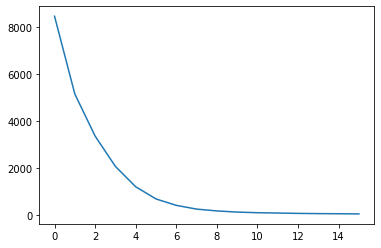

Epoch 1/2
58/58 [==============================] - 0s 8ms/step - loss: 4598.8896
Epoch 2/2
58/58 [==============================] - 0s 7ms/step - loss: 3314.2502




1it [02:08, 128.08s/it]

Epoch 1/50
231/231 [==============================] - 4s 12ms/step - loss: 11240.1835 - val_loss: 5229.6997
roc-auc_val: 0.9029
Epoch 2/50
231/231 [==============================] - 2s 9ms/step - loss: 6088.0873 - val_loss: 4350.9131
roc-auc_val: 0.9208
Epoch 3/50
231/231 [==============================] - 2s 9ms/step - loss: 4121.3999 - val_loss: 3814.5806
roc-auc_val: 0.9374
Epoch 4/50
231/231 [==============================] - 2s 9ms/step - loss: 2650.1107 - val_loss: 3532.0950
roc-auc_val: 0.9454
Epoch 5/50
231/231 [==============================] - 2s 9ms/step - loss: 1494.2713 - val_loss: 3418.0605
roc-auc_val: 0.9513
Epoch 6/50
231/231 [==============================] - 2s 9ms/step - loss: 832.5476 - val_loss: 3382.9875
roc-auc_val: 0.9551
Epoch 7/50
231/231 [==============================] - 2s 9ms/step - loss: 471.9562 - val_loss: 3419.0520
roc-auc_val: 0.9555
Epoch 8/50
231/231 [==============================] - 2s 9ms/step - loss: 277.5654 - val_loss: 3748.1570
roc-auc_val: 

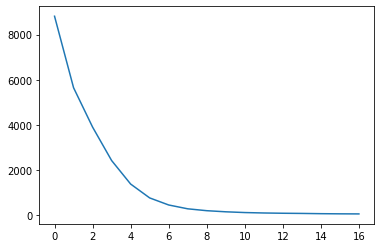

Epoch 1/2
58/58 [==============================] - 0s 8ms/step - loss: 2984.0835
Epoch 2/2
58/58 [==============================] - 0s 8ms/step - loss: 1915.5331




2it [04:21, 129.68s/it]

Epoch 1/50
231/231 [==============================] - 4s 12ms/step - loss: 10838.9538 - val_loss: 6084.5947
roc-auc_val: 0.8989
Epoch 2/50
231/231 [==============================] - 2s 9ms/step - loss: 5681.1395 - val_loss: 5359.5303
roc-auc_val: 0.9118
Epoch 3/50
231/231 [==============================] - 2s 9ms/step - loss: 4046.6438 - val_loss: 4548.7188
roc-auc_val: 0.9272
Epoch 4/50
231/231 [==============================] - 2s 9ms/step - loss: 2587.6798 - val_loss: 4241.8135
roc-auc_val: 0.9396
Epoch 5/50
231/231 [==============================] - 2s 9ms/step - loss: 1394.1811 - val_loss: 4260.8691
roc-auc_val: 0.9412
Epoch 6/50
231/231 [==============================] - 2s 9ms/step - loss: 788.7753 - val_loss: 4278.2090
roc-auc_val: 0.9453
Epoch 7/50
231/231 [==============================] - 2s 9ms/step - loss: 469.1163 - val_loss: 4370.2910
roc-auc_val: 0.9456
Epoch 8/50
231/231 [==============================] - 2s 9ms/step - loss: 313.6762 - val_loss: 4437.8477
roc-auc_val: 

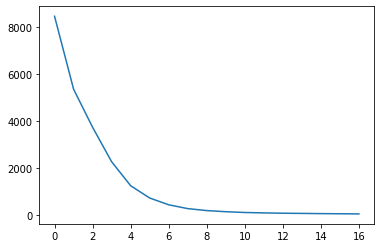

Epoch 1/2
58/58 [==============================] - 0s 8ms/step - loss: 3463.0862
Epoch 2/2
58/58 [==============================] - 0s 8ms/step - loss: 2339.8560




3it [06:36, 131.38s/it]

Epoch 1/50
231/231 [==============================] - 4s 12ms/step - loss: 11110.3092 - val_loss: 6277.3921
roc-auc_val: 0.9062
Epoch 2/50
231/231 [==============================] - 2s 9ms/step - loss: 5895.5037 - val_loss: 4705.6055
roc-auc_val: 0.9315
Epoch 3/50
231/231 [==============================] - 2s 9ms/step - loss: 4090.2348 - val_loss: 4228.2153
roc-auc_val: 0.9396
Epoch 4/50
231/231 [==============================] - 2s 9ms/step - loss: 2669.4811 - val_loss: 3615.2688
roc-auc_val: 0.952
Epoch 5/50
231/231 [==============================] - 2s 9ms/step - loss: 1511.7641 - val_loss: 3498.6624
roc-auc_val: 0.9601
Epoch 6/50
231/231 [==============================] - 2s 9ms/step - loss: 882.4839 - val_loss: 3654.1211
roc-auc_val: 0.9626
Epoch 7/50
231/231 [==============================] - 2s 9ms/step - loss: 500.0108 - val_loss: 3673.5149
roc-auc_val: 0.9634
Epoch 8/50
231/231 [==============================] - 2s 9ms/step - loss: 315.6638 - val_loss: 3658.7087
roc-auc_val: 0

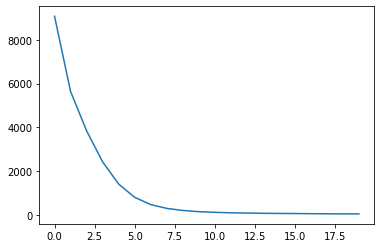

Epoch 1/2
58/58 [==============================] - 0s 8ms/step - loss: 2744.5330
Epoch 2/2
58/58 [==============================] - 0s 8ms/step - loss: 1991.7146




4it [09:08, 137.47s/it]

Epoch 1/50
231/231 [==============================] - 4s 12ms/step - loss: 10881.8110 - val_loss: 7254.8931
roc-auc_val: 0.8862
Epoch 2/50
231/231 [==============================] - 2s 9ms/step - loss: 5678.8971 - val_loss: 6374.8467
roc-auc_val: 0.9004
Epoch 3/50
231/231 [==============================] - 2s 9ms/step - loss: 3817.4790 - val_loss: 5902.8989
roc-auc_val: 0.9119
Epoch 4/50
231/231 [==============================] - 2s 9ms/step - loss: 2558.5590 - val_loss: 5328.7446
roc-auc_val: 0.9244
Epoch 5/50
231/231 [==============================] - 2s 9ms/step - loss: 1470.9665 - val_loss: 4933.9326
roc-auc_val: 0.9335
Epoch 6/50
231/231 [==============================] - 2s 9ms/step - loss: 803.8441 - val_loss: 5049.7124
roc-auc_val: 0.9357
Epoch 7/50
231/231 [==============================] - 2s 9ms/step - loss: 477.9489 - val_loss: 5202.9731
roc-auc_val: 0.9379
Epoch 8/50
231/231 [==============================] - 2s 9ms/step - loss: 304.6199 - val_loss: 5204.1279
roc-auc_val: 

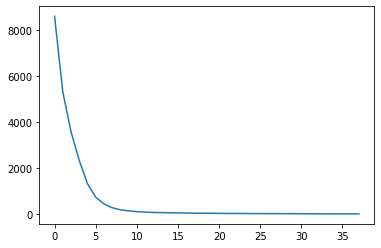

Epoch 1/2
58/58 [==============================] - 0s 8ms/step - loss: 3758.1423
Epoch 2/2
58/58 [==============================] - 0s 8ms/step - loss: 2622.1123




5it [13:30, 162.05s/it]


In [17]:
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
splits=StratifiedKFold(n_splits=5)
gc.collect()
pre=np.zeros((506691,1))
tst=tst.drop(['isFraud'],1)
for train_index,test_index in tqdm(splits.split(trn,trn['isFraud'])):
  X_train, X_test = trn.loc[train_index], trn.loc[test_index]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  ids={}
  for en,id in enumerate(X_train['id'].unique()):
    ids[id]=en+2
  X_train['id']=X_train['id'].map(lambda x: ids.get(x,1))
  X_test['id']=X_test['id'].map(lambda x: ids.get(x,1))
  dim=X_train['id'].nunique()+2
  gc.collect()
  trn_id,tst_id=X_train['id'],X_test['id']
  X_train=X_train.drop(['isFraud','id'],1)
  X_test=X_test.drop(['isFraud','id'],1)
  mod=load_model(dim)
  roc = RocCallback(validation_data=([X_test,tst_id], y_test),epochs=10)
  mod.compile(optimizer=Nadam(),loss=rac)
  es=EarlyStopping(monitor='acu_val',min_delta=0.0001,mode='min',restore_best_weights=True,patience=10)
  hist = mod.fit([X_train,trn_id],y_train,validation_data=([X_test,tst_id],y_test),batch_size=2048,epochs=50,callbacks=[roc])
  
  plt.plot(hist.history['loss'])
  plt.savefig('/content/gdrive/My Drive/fraud/roc_approximation_'+str(en)+'.png')
  plt.show()

  del[(X_train,y_train)]
  gc.collect()

  mod.fit([X_test,tst_id],y_test,epochs=2,batch_size=2048)
  pre+=mod.predict([tst.drop(['id'],1),tst['id'].map(lambda x: ids.get(x,1))])/5
  
  del([X_test,y_test,mod])
  gc.collect()

In [18]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre
sub=sub.set_index('TransactionID')
sub.head()

,isFraud
TransactionID,
3663549,0.047033
3663550,0.056691
3663551,0.162671
3663552,0.093753
3663553,0.070247


In [19]:
sub.to_csv('sub.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


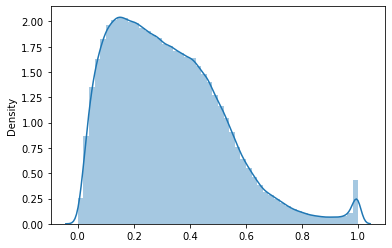

In [20]:
import seaborn as sns
sns.distplot(pre)